In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import scipy
import scipy.io as sio
from utility_functions import sparsifyDynamics, poolData

In [141]:
# load saved data from .mat file
data = sio.loadmat('../models/data/REFSIM-25hr.mat', chars_as_strings=1)
t = data['t']
x = data['x']
names = data['names']
names = np.array([str(''.join(letter)) for letter_array in names for letter in letter_array])
print(names)

# only keep non-constant data
dynamics = [0,1,2,3,4,5,6,7,8,9]
x = x[:, dynamics]
names = names[dynamics]
names = ['Art', 'Gut', 'GutL', 'Lung', 'Ven', 'Rest', 'Liver', 'Metab', 'Kidney', 'Tubules']

# scale all data from Mols/L to MilliMols/L
x *= 1000

['VArt.CArt' 'VGut.CGut' 'VGutLumen.AGutlumen' 'VLung.CLung' 'VVen.CVen'
 'VRest.CRest' 'VLiver.CLiver' 'VLiver.CMetabolized' 'VKidney.CKidney'
 'VKidneyTubules.CTubules' 'QCardiac' 'QGut' 'QLiver' 'QKidney' 'QRest'
 'Qgfr' 'VTotal']


['seaborn-pastel', 'seaborn-paper', 'seaborn-white', 'tableau-colorblind10', '_classic_test', 'seaborn-notebook', 'seaborn-poster', 'seaborn', 'seaborn-dark', 'fivethirtyeight', 'seaborn-darkgrid', 'Solarize_Light2', 'seaborn-bright', 'seaborn-talk', 'fast', 'seaborn-colorblind', 'dark_background', 'ggplot', 'seaborn-muted', 'bmh', 'seaborn-whitegrid', 'grayscale', 'seaborn-dark-palette', 'seaborn-deep', 'seaborn-ticks', 'classic']


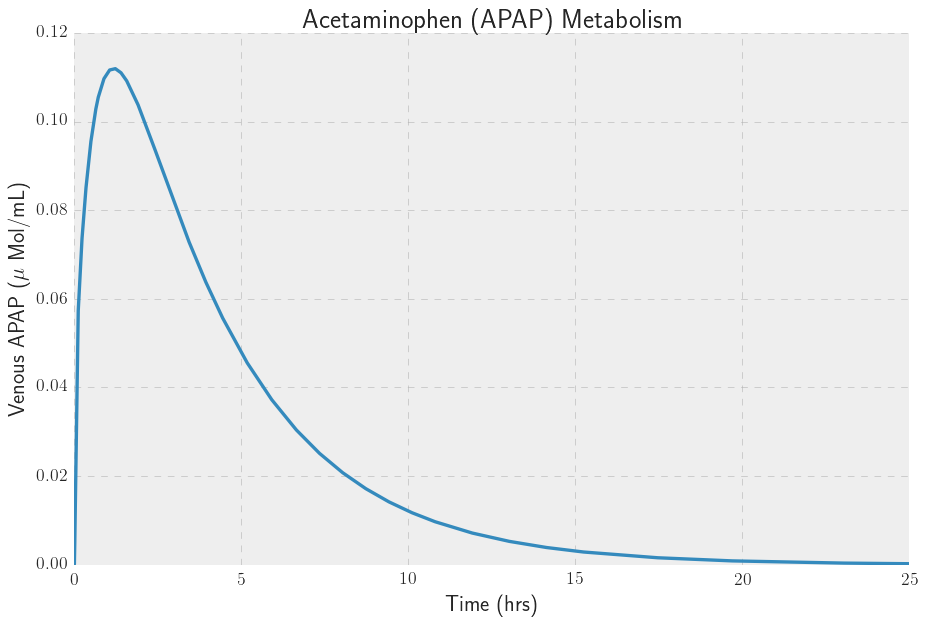

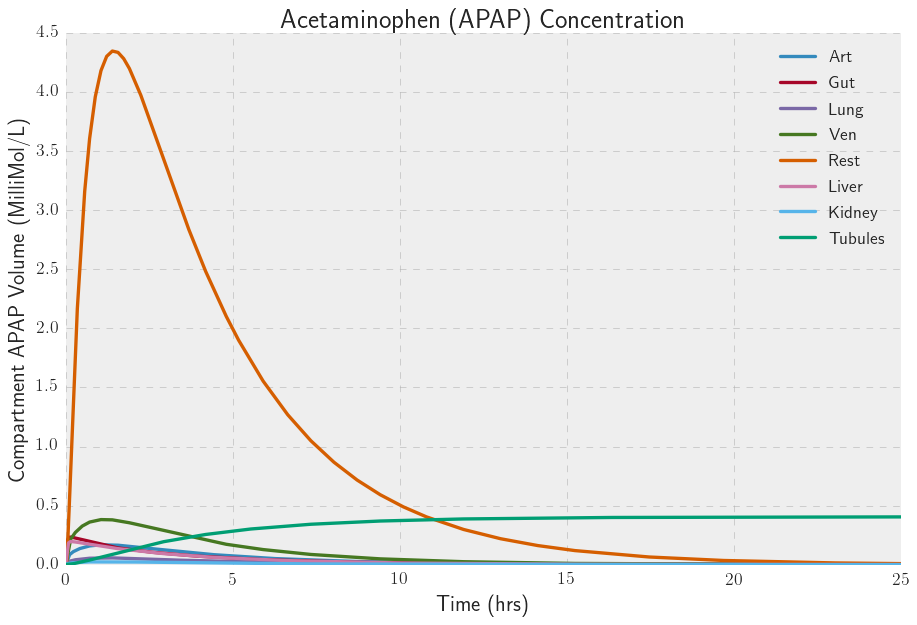

In [168]:
# change plot display style
# plt.style.use('dark_background')
# plt.style.use('classic')
plt.style.use('bmh')
# plt.style.use('seaborn-dark')
print(plt.style.available)
plt.rcParams['font.size'] = 22
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 10
plt.rcParams['text.usetex'] = True

# plot the amount of APAP in venous blood over time
venousAPAPInLiters = x[:, 4] / 3.41;
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(t, venousAPAPInLiters)
plt.xlabel('Time (hrs)')
plt.ylabel(r'Venous APAP ($\mu$ Mol/mL)')
plt.title('Acetaminophen (APAP) Metabolism')
plt.show()

compartments = [0,1,3,4,5,6,8,9]

# Create plots with pre-defined labels.
fig, ax = plt.subplots(figsize=(12,8))
for c in compartments:
      ax.plot(t, x[:, c], label=names[c])
plt.xlabel('Time (hrs)')
plt.ylabel('Compartment APAP Volume (MilliMol/L)')
plt.title('Acetaminophen (APAP) Concentration')
ax.legend(loc='upper right')
plt.show()

In [138]:
# Run SINDy algorithm
xdf = pd.DataFrame(x)
n, nVars = x.shape
xdf_dot = xdf.diff()

# we lose one row, need to zero pad (or maybe not)
#x_dot = pd.concat([pd.DataFrame(np.zeros((1, nVars))), x_dot])
xdf_dot.loc[0, :] = 0.0

# variable labeling
cols = [i for i in names]
xdf.columns = cols
dot_labels = pd.Index([s for s in cols])

# SINDy params
polyorder = 4
lam = 0.0001
usesine = 0

# generate data
Theta = pd.DataFrame()
Theta = poolData(xdf, nVars, polyorder, usesine)

# run SINDy
xdf_hat = sparsifyDynamics(Theta, xdf_dot, lam)
xdf_hat = xdf_hat.set_index(dot_labels)
print(xdf_hat.shape)
# xdf_hat = xdf_hat.iloc[:, 1:]
# print(xdf_hat.shape)
# xdf_hat.columns = dot_labels
# print(dot_labels)
# print(cols)
# Xhat_df.columns = cols


(10, 1001)


In [139]:
# Display result
xdf_hat.T

,Art,Gut,GutL,Lung,Ven,Rest,Liver,Metab,Kidney,Tubules
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000
Art,0.0,-0.000000,-0.000000,0.0,0.000000,0.000000,-0.000000,0.0,0.0,0.000000
Gut,0.0,0.000000,-0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,-0.000000
GutL,0.0,0.000000,-0.000000,0.0,0.000000,0.000000,0.000000,-0.0,0.0,-0.000067
Lung,0.0,-0.000000,-0.000000,0.0,0.000000,0.000000,-0.000000,0.0,0.0,0.000000
Ven,0.0,-0.000000,-0.000000,0.0,0.000000,0.000000,-0.000000,0.0,0.0,0.000000
Rest,-0.0,-0.000669,0.000000,-0.0,-0.000000,-0.000000,-0.000616,0.0,-0.0,0.000000
Liver,0.0,-0.000000,-0.000000,0.0,0.000000,0.000000,-0.000000,0.0,0.0,0.000000
Metab,-0.0,-0.000000,0.000000,-0.0,-0.000000,-0.001971,-0.000000,0.0,-0.0,0.000000
Kidney,0.0,-0.083958,-0.000000,0.0,0.000000,0.000000,-0.000000,0.0,0.0,0.000000


In [140]:
xdf_hat.to_csv('../models/data/dynamics.csv')